<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Подготовка-выводы" data-toc-modified-id="Подготовка-выводы-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка выводы</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Анализ-выводы" data-toc-modified-id="Анализ-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ выводы</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Обучение-выводы" data-toc-modified-id="Обучение-выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение выводы</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Проверка-модели-на-адекватность-выводы" data-toc-modified-id="Проверка-модели-на-адекватность-выводы-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Проверка модели на адекватность выводы</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Подготовка-выводы" data-toc-modified-id="Подготовка-выводы-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Подготовка выводы</a></span></li><li><span><a href="#Анализ-выводы" data-toc-modified-id="Анализ-выводы-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Анализ выводы</a></span></li><li><span><a href="#Обучение-выводы" data-toc-modified-id="Обучение-выводы-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Обучение выводы</a></span></li><li><span><a href="#Тестирование-выводы" data-toc-modified-id="Тестирование-выводы-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Тестирование выводы</a></span></li><li><span><a href="#Проверка-модели-на-адекватность-выводы" data-toc-modified-id="Проверка-модели-на-адекватность-выводы-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Проверка модели на адекватность выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Требованя:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [2]:
try:
    data = pd.read_csv('taxi.csv',index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

Данные представленные в таблице

In [3]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Информация по данным.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Статистические данные по  количеству заказов.

In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество пропусков в данных. 

In [6]:
data.isna().sum()

num_orders    0
dtype: int64

Проверим является ли индекс данных монотонным в порядке возрастания.

In [7]:
data.index.is_monotonic_increasing

True

Выполним сортировку данных по возрастанию.

In [8]:
data.sort_index(ascending=True, inplace=True)

Выполним объединение данных с интервалом 1 час

In [9]:
data = data.resample('1H').sum() 

In [10]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Подготовка выводы
Загруженные данные  о заказах такси в аэропортах в качестве индекса принято время заказа.

Данные  предоставлены в количестве 4416 строк  одна строка  один час.

Формат данных заказов представлен  “int64”  

Минимальное  количество заказов 0.

Максимальное 462.

Среднее значение  84.

Стандартное отклонение заказов 45.

Пропуски в данных отсутствуют.

## Анализ

In [11]:
figsize=(14,7)

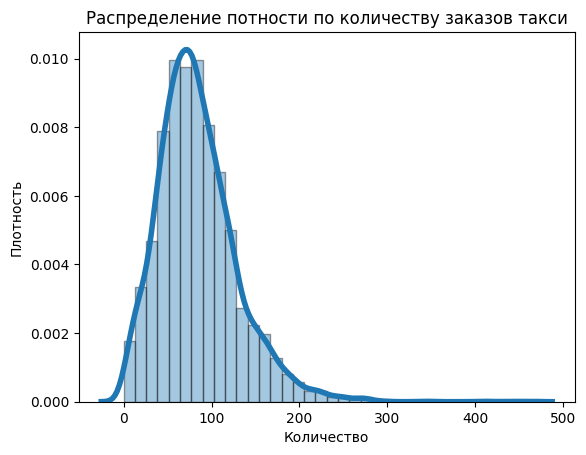

In [12]:
#data.plot(kind='hist', bins=60,figsize=figsize);
sns.distplot(data, hist=True, kde=True, 
             bins=int(180/5), 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Распределение потности по количеству заказов такси') 
plt.xlabel('Количество')  
plt.ylabel('Плотность')
plt.show()

In [13]:
data_research = data.copy()
data_research['mean'] = data_research['num_orders'].shift().rolling(24*7).mean()
data_research['std'] = data_research['num_orders'].shift().rolling(24*7).std()

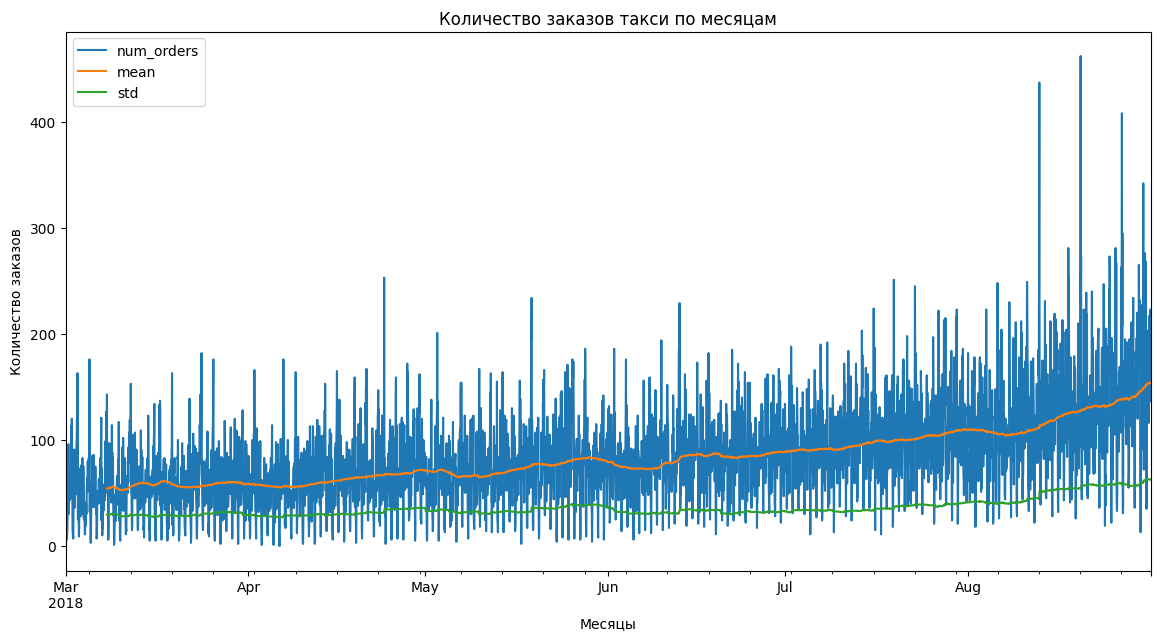

In [14]:
data_research.plot(figsize=figsize)


plt.title('Количество заказов такси по месяцам') 
plt.xlabel('Месяцы')  
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [15]:
decomposed = seasonal_decompose(data)

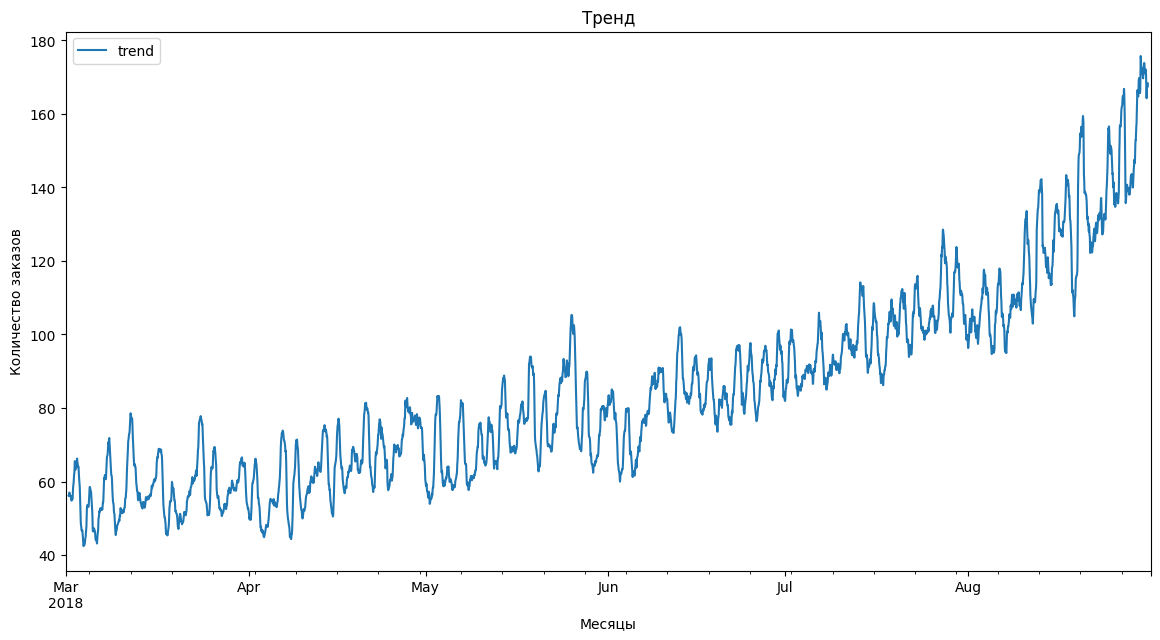

In [16]:
figsize=(14,7)
decomposed.trend.plot(figsize=figsize)

plt.title('Тренд') 
plt.xlabel('Месяцы')  
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

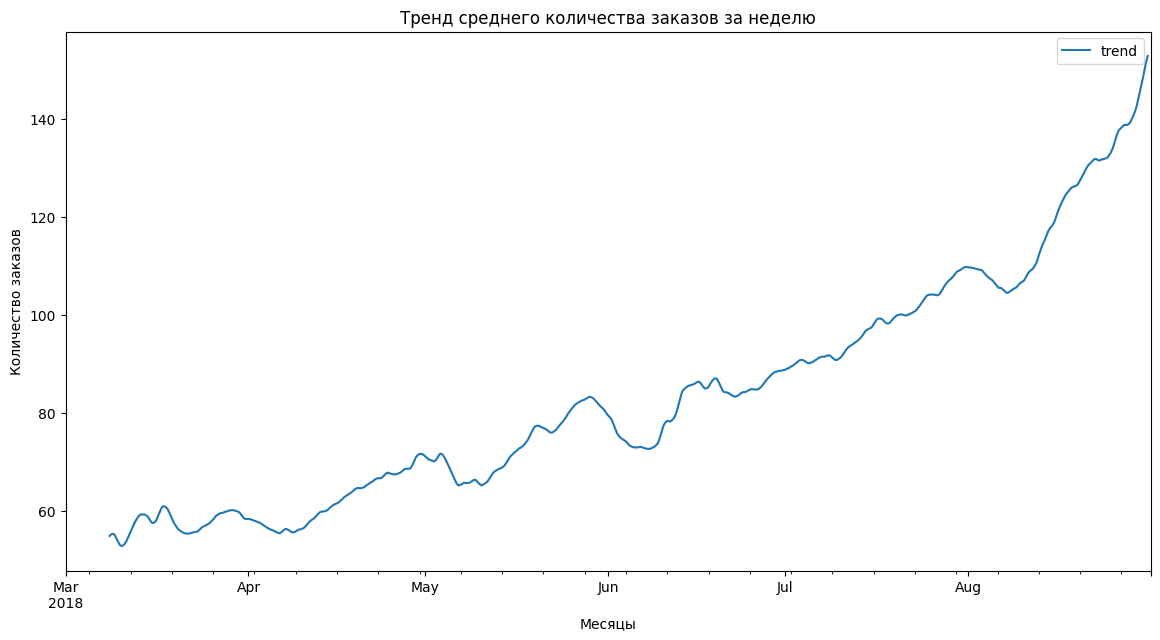

In [17]:
decomposed.trend.rolling(24*7).mean().plot(figsize=figsize)

plt.title('Тренд среднего количества заказов за неделю') 
plt.xlabel('Месяцы')  
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

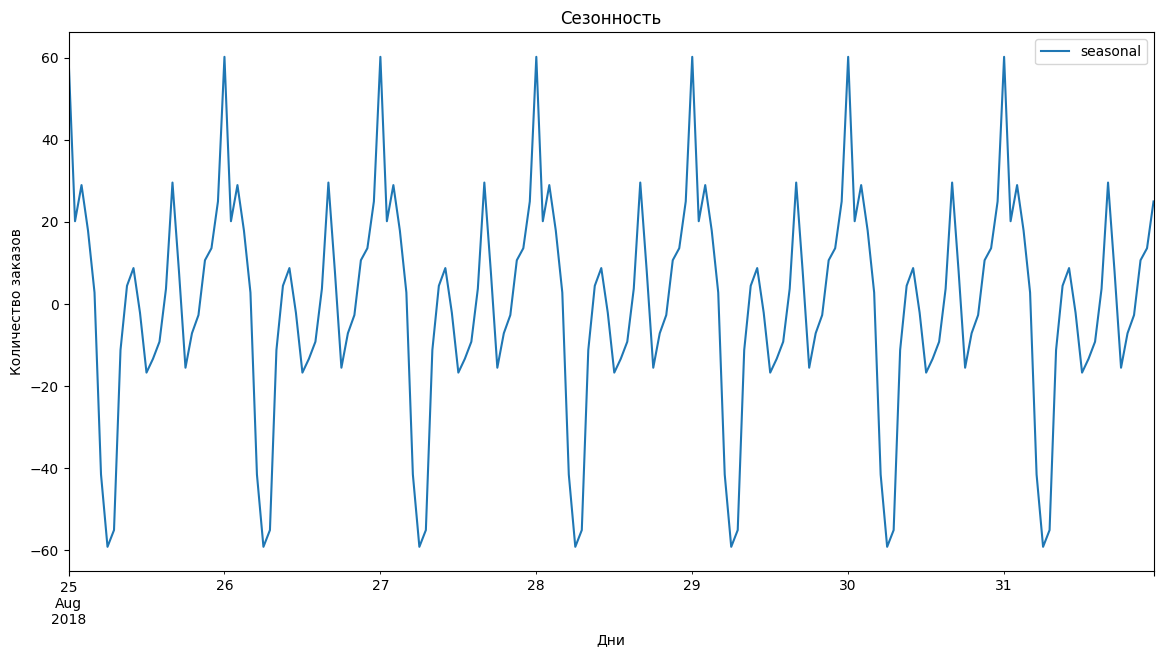

In [18]:
decomposed.seasonal.tail(24*7).plot(figsize=figsize)
plt.title('Сезонность') 
plt.xlabel('Дни')  
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

## Анализ выводы

Из полученных графиков  можно сделать вывод, что мы имеем восходящий  тренд заказов с локальным падениями.
В полученных графиках присутствует дневная сезонность  с восходящим трендом к вечеру.
В сезоном графике можно выделить три  пика:

Утренний 

Дневной 

Вечерний.

После всех пиков наблюдаются падения.

В аэропортах активность пассажиров обычно увеличивается в определенные периоды: утром, днем и вечером, когда прибывают и отправляются рейсы. Поэтому заказы на такси могут возрастать в соответствии с этими пиками

## Обучение

Для прогноза временого ряда добавим признаки.


In [19]:
def make_features(data, max_lag, rolling_mean_size):# < напишите код здесь >
    data_features= data.copy()
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek

    for lag in range(1, max_lag + 1):
            data_features['lag_{}'.format(lag)] =  data['num_orders'].shift(lag) 
    data_features['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_features


In [20]:
data_features = make_features(data, 25, 40) 
data_features

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,177.0,164.150
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,162.725
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,161.925


In [21]:
train, test = train_test_split(data_features, shuffle=False, test_size=0.1)
train = train.dropna()

In [22]:
train.head(5)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 16:00:00,82,2,4,59.0,44.0,45.0,36.0,91.0,54.0,45.0,...,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,54.550
2018-03-02 17:00:00,83,2,4,82.0,59.0,44.0,45.0,36.0,91.0,54.0,...,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,53.500
2018-03-02 18:00:00,89,2,4,83.0,82.0,59.0,44.0,45.0,36.0,91.0,...,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,53.450
2018-03-02 19:00:00,49,2,4,89.0,83.0,82.0,59.0,44.0,45.0,36.0,...,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,53.900
2018-03-02 20:00:00,93,2,4,49.0,89.0,83.0,82.0,59.0,44.0,45.0,...,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,53.475


Проверим интервалы разбиения тренировочных и тестовых выборок.

In [23]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 16:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [24]:
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

target_train = train['num_orders']
target_test = test['num_orders'] 

Проверим размеры тренировочных и тестовых выборок. 

In [25]:
features_train.shape

(3934, 28)

In [26]:
target_train.shape

(3934,)

In [27]:
features_test.shape

(442, 28)

In [28]:
target_test.shape

(442,)

Обучим модели и подберем гиперпараметры.
В качестве расчетных моделей выберем:

LinearRegression

LGBMRegressor

CatBoostRegressor


In [29]:
lr = LinearRegression()
lgbm =LGBMRegressor(random_state=42)
cat = CatBoostRegressor(random_state=42)

Зададим параметры для подбора методом GridSearchCV

In [30]:
param_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

param_lgbm = {
   'num_leaves': [20, 40, 80],
#   'min_data_in_leaf': [10,30,40],

  
    'max_depth': [ 5, 10, 15],
#    'max_bin':[5,10,15],

    'n_estimators':[250, 500, 1000],

#    'lambda_l1':[0.1,0.2,0.3],
#   'lambda_l2':[0.08,0.09,0.1],
            }

param_cat = {
  
    'iterations': [50, 100, 200],
    'learning_rate': [0.03, 0.1],   
    'depth': [3, 6, 9]
            }

Обучим модель LinearRegression и  получим метрику качествам RMSE

In [31]:
tscv = TimeSeriesSplit(n_splits=3)

In [32]:
grid_search_lr = GridSearchCV(lr, param_lr, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)


In [33]:
%%time
grid_search_lr.fit(features_train, target_train)

CPU times: total: 141 ms
Wall time: 4.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

In [34]:
print('Значение метрики качества RMSE:',np.sqrt(-grid_search_lr.best_score_) )

Значение метрики качества RMSE: 27.72382069842759


Обучим модель LGBMRegressor c подбором гиперпараметров методом  GridSearchCV и  получим метрику качествам RMSE

In [36]:
grid_search_lgbm = GridSearchCV(lgbm, param_lgbm, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv);

In [37]:
%%time
grid_search_lgbm.fit(features_train, target_train);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Number of data points in the train set: 3934, number of used features: 28
[LightGBM] [Info] Start training from score 78.532028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [38]:
print('Значение метрики качества RMSE:',np.sqrt(-grid_search_lgbm.best_score_) )

Значение метрики качества RMSE: 27.66232168408495


Обучим модель CatBoostRegressor c подбором гиперпараметров методом  GridSearchCV и  получим метрику качествам RMSE

In [39]:
grid_search_cat = GridSearchCV(cat, param_cat, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv);

In [40]:
%%time
grid_search_cat.fit(features_train, target_train);

0:	learn: 37.1054795	total: 140ms	remaining: 27.9s
1:	learn: 35.5489619	total: 145ms	remaining: 14.4s
2:	learn: 34.1273326	total: 150ms	remaining: 9.83s
3:	learn: 33.0627055	total: 154ms	remaining: 7.56s
4:	learn: 32.0046145	total: 159ms	remaining: 6.19s
5:	learn: 31.1239080	total: 163ms	remaining: 5.28s
6:	learn: 30.3344310	total: 168ms	remaining: 4.64s
7:	learn: 29.6465623	total: 173ms	remaining: 4.14s
8:	learn: 29.0791538	total: 177ms	remaining: 3.76s
9:	learn: 28.4896555	total: 182ms	remaining: 3.45s
10:	learn: 27.9671746	total: 186ms	remaining: 3.2s
11:	learn: 27.5915160	total: 190ms	remaining: 2.98s
12:	learn: 27.1741924	total: 195ms	remaining: 2.8s
13:	learn: 26.8747045	total: 199ms	remaining: 2.65s
14:	learn: 26.5760922	total: 204ms	remaining: 2.51s
15:	learn: 26.2616890	total: 208ms	remaining: 2.4s
16:	learn: 25.9913702	total: 214ms	remaining: 2.31s
17:	learn: 25.7643523	total: 219ms	remaining: 2.21s
18:	learn: 25.5407567	total: 223ms	remaining: 2.13s
19:	learn: 25.3203537	tot

180:	learn: 17.4408168	total: 966ms	remaining: 101ms
181:	learn: 17.4325134	total: 971ms	remaining: 96ms
182:	learn: 17.4083916	total: 977ms	remaining: 90.8ms
183:	learn: 17.3563461	total: 984ms	remaining: 85.6ms
184:	learn: 17.3196282	total: 989ms	remaining: 80.2ms
185:	learn: 17.2689441	total: 995ms	remaining: 74.9ms
186:	learn: 17.2349800	total: 1000ms	remaining: 69.5ms
187:	learn: 17.2063623	total: 1s	remaining: 64.1ms
188:	learn: 17.1664538	total: 1.01s	remaining: 58.7ms
189:	learn: 17.1368783	total: 1.01s	remaining: 53.3ms
190:	learn: 17.0989428	total: 1.02s	remaining: 48ms
191:	learn: 17.0732989	total: 1.02s	remaining: 42.6ms
192:	learn: 17.0342337	total: 1.03s	remaining: 37.2ms
193:	learn: 16.9984456	total: 1.03s	remaining: 31.9ms
194:	learn: 16.9633907	total: 1.03s	remaining: 26.5ms
195:	learn: 16.9143711	total: 1.04s	remaining: 21.2ms
196:	learn: 16.8890660	total: 1.04s	remaining: 15.9ms
197:	learn: 16.8431157	total: 1.05s	remaining: 10.6ms
198:	learn: 16.8239215	total: 1.05s

In [41]:
print('Значение метрики качества RMSE:',np.sqrt(-grid_search_cat.best_score_))

Значение метрики качества RMSE: 26.876095905346737


## Обучение выводы

На этапе обучения все модели показали близкое качество метрики RMSE к друг другу и лежит в диапазоне от 26.87 до 27.72.

В качестве лучшей  модели на этапе обучения показала себя CatBoostRegressor со значением метрики RMSE  26.87. 

## Тестирование

Выполним тестирование модели CatBoostRegressor 

In [42]:
pred_test=grid_search_cat.predict(features_test)

rmse = np.sqrt(mean_squared_error(target_test,pred_test))
print('Значение метрики качества RMSE:',rmse)

Значение метрики качества RMSE: 42.26338334463002


Анализ предсказаний и лучшей модели CatBoostRegressor 

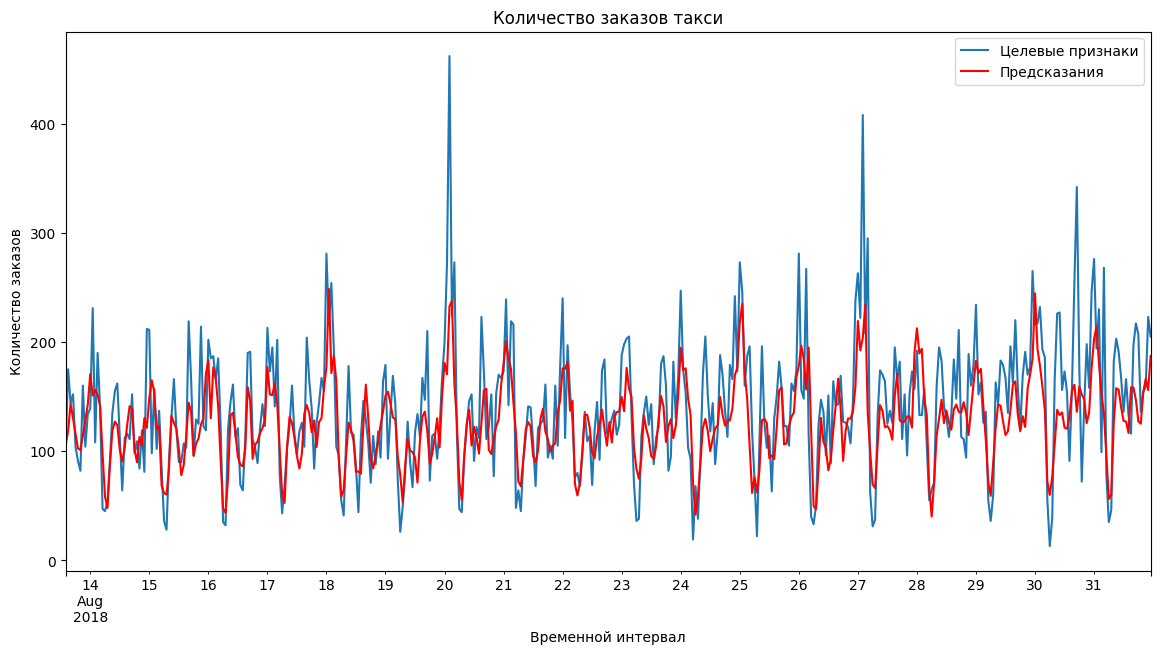

In [43]:
target_test.plot(figsize=figsize, label = "Целевые признаки")
pd.Series(pred_test, index=target_test.index).plot(figsize=figsize, color='red',label = "Предсказания")
plt.title('Количество заказов такси') 
plt.xlabel('Временной интервал')  
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Предсказания модели и целевые значения в целом соответствуют друг другу. 
Присутствует существенно расхождение в целевом признаке и предсказании модели каждый седьмой день. Данные дни выпадают на понедельник, как правило в понедельник люди отправляются в командировки.  


# Тестирование выводы
На этапе тестирования модель CatBoostRegressor показала более низкое качество метрики RMSE 42.26 

Несмотря на падения качества метрики ее значение удовлетворяет требованию технического задания.

## Проверка модели на адекватность

In [44]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr = dummy_regr.fit(features_train, target_train)

dummy_regr_pred= dummy_regr.predict(features_test)


rmse_test_lgbm = np.sqrt(mean_squared_error(target_test,dummy_regr_pred))
rmse_test_lgbm

84.56979565201173

## Проверка модели на адекватность выводы
Проверка модели на адекватность средним значением показала, что метрики  рассматриваемых моделей значительно выше, следовательно их можно принять в работу


## Выводы

Для компании «Чётенькое такси» была построена модель на исторических данных.

Лучшей метрикой качества обладает модель CatBoostRegressor с значением метрики RMSE 42.26. 

Это говорит, что прогнозная величина, будет соответствовать действительности с точностью  +/- 42 заказа.  

Значение метрики *RMSE* на тестовой выборке не превышает требуемого порога, указанного в техническом задании 48.


## Подготовка выводы
Загруженные данные  о заказах такси в аэропортах в качестве индекса принято время заказа.

Данные  предоставлены в количестве 4416 строк  одна строка  один час.

Формат данных заказов представлен  “int64”  

Минимальное  количество заказов 0.

Максимальное 462.

Среднее значение  84.

Стандартное отклонение заказов 45.

Пропуски в данных отсутствуют.


## Анализ выводы

Из полученных графиков  можно сделать вывод, что мы имеем восходящий  тренд заказов с локальным падениями.
В полученных графиках присутствует дневная сезонность  с восходящим трендом к вечеру.
В сезоном графике можно выделить три  пика:

Утренний 

Дневной 

Вечерний.

После всех пиков наблюдаются падения.

В аэропортах активность пассажиров обычно увеличивается в определенные периоды: утром, днем и вечером, когда прибывают и отправляются рейсы. Поэтому заказы на такси могут возрастать в соответствии с этими пиками



## Обучение выводы

На этапе обучения все модели показали близкое качество метрики RMSE к друг другу и лежит в диапазоне от 26.87 до 27.72.

В качестве лучшей  модели на этапе обучения показала себя CatBoostRegressor со значением метрики RMSE  26.87. 

## Тестирование выводы

На этапе тестирования модель CatBoostRegressor показала более низкое качество метрики RMSE 42.26 

Несмотря на падения качества метрики ее значение удовлетворяет требованию технического задания.

## Проверка модели на адекватность выводы
Проверка модели на адекватность средним значением показала, что метрики рассматриваемых моделей значительно выше, следовательно их можно принять в работ